In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import scipy.io as sio

np.random.seed(0)

In [2]:
# DoG filter as a model of LGN
def DoG(img, ksize=(5,5), sigma=1.3, k=1.6):
    g1 = cv2.GaussianBlur(img, ksize, sigma)
    g2 = cv2.GaussianBlur(img, ksize, k*sigma)
    dog = g1 - g2
    return (dog - dog.min())/(dog.max()-dog.min())

# Gaussian mask for inputs
def GaussianMask(sizex=16, sizey=16, sigma=5):
    x = np.arange(0, sizex, 1, float)
    y = np.arange(0, sizey, 1, float)
    x, y = np.meshgrid(x,y)
    
    x0 = sizex // 2
    y0 = sizey // 2
    mask = np.exp(-((x-x0)**2 + (y-y0)**2) / (2*(sigma**2)))
    return mask / np.sum(mask)

In [3]:
# Preprocess of inputs
num_images = 10
num_iter = 5000

# datasets from http://www.rctn.org/bruno/sparsenet/
mat_images = sio.loadmat('./datasets/IMAGES.mat')
imgs = mat_images['IMAGES']
mat_images_raw = sio.loadmat('datasets/IMAGES_RAW.mat')
imgs_raw = mat_images_raw['IMAGESr']

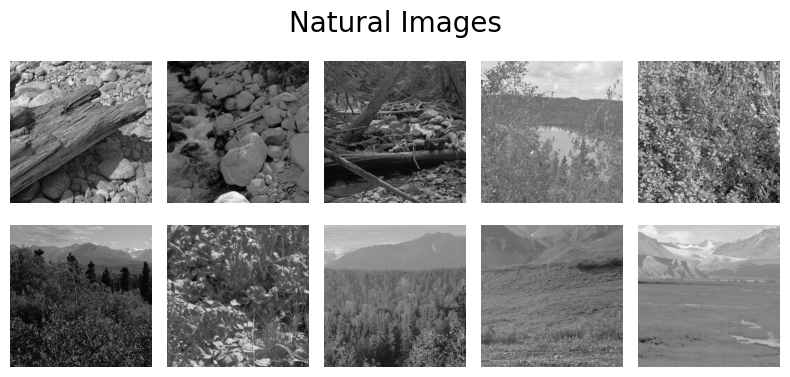

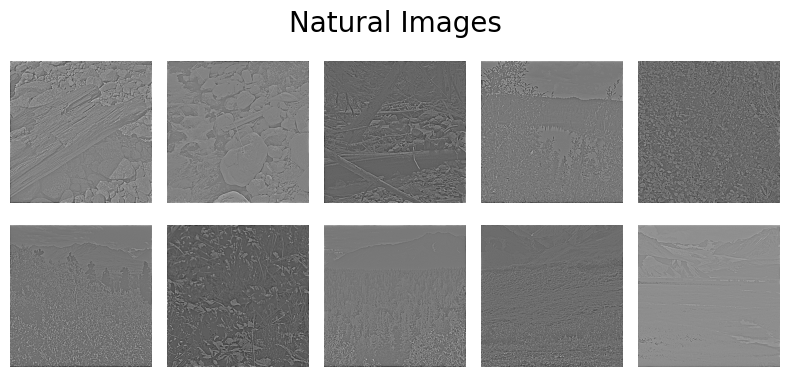

In [12]:
# Plot datasets
fig = plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imgs_raw[:,:,i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
fig.suptitle("Natural Images", fontsize=20)
plt.subplots_adjust(top=0.9)  


fig = plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(imgs[:,:,i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
fig.suptitle("Natural Images", fontsize=20)
plt.subplots_adjust(top=0.9)  

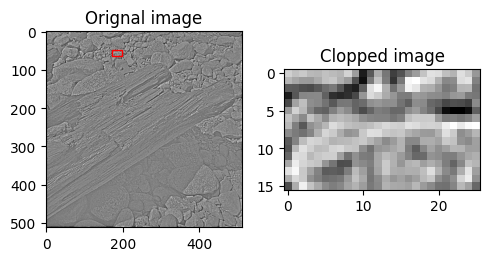

In [5]:
# Get image from imglist
img = imgs[:, :, 0]
H, W = img.shape

# Get the coordinates of the upper left corner of clopping image randomly.
beginx = np.random.randint(0, W-27)
beginy = np.random.randint(0, H-17)
img_clopped = img[beginy:beginy+16, beginx:beginx+26]

# Clop three inputs
inputs = [img_clopped[:, 0:16], 
          img_clopped[:, 5:21], 
          img_clopped[:, 10:26]]

# Show clopped images
plt.figure(figsize=(5,10))
ax1 = plt.subplot(1,2,1)
plt.title("Orignal image")
plt.imshow(img, cmap="gray")
ax1.add_patch(patches.Rectangle(xy=(beginx, beginy), 
                                width=26, height=16, ec='red', fill=False))

ax2 = plt.subplot(1,2,2)
plt.title("Clopped image")
plt.imshow(img_clopped, cmap="gray")
plt.tight_layout()
plt.show()

In [6]:
class RaoBallard1999Model:
    def __init__(self, dt=1, sigma2=1, sigma2_td=10):
        self.dt = dt
        self.inv_sigma2 = 1/sigma2 # 1 / sigma^2        
        self.inv_sigma2_td = 1/sigma2_td # 1 / sigma_td^2
        
        self.k1 = 0.3 # k_1: update rate
        self.k2 = 0.2 # k_2: learning rate
        
        self.lam = 0.02 # sparsity rate
        self.alpha = 1
        self.alphah = 0.05
        
        self.num_units_level0 = 256
        self.num_units_level1 = 32
        self.num_units_level2 = 128
        self.num_level1 = 3
        
        U = np.random.randn(self.num_units_level0, 
                            self.num_units_level1)
        Uh = np.random.randn(int(self.num_level1*self.num_units_level1),
                             self.num_units_level2)
        self.U = U.astype(np.float32) * np.sqrt(2/(self.num_units_level0+self.num_units_level1))
        self.Uh = Uh.astype(np.float32) * np.sqrt(2/(int(self.num_level1*self.num_units_level1)+self.num_units_level2)) 
                
        self.r = np.zeros((self.num_level1, self.num_units_level1))
        self.rh = np.zeros((self.num_units_level2))
    
    def initialize_states(self, inputs):
        self.r = inputs @ self.U 
        self.rh = self.Uh.T @ np.reshape(self.r, (int(self.num_level1*self.num_units_level1)))
    
    def calculate_total_error(self, error, errorh):
        recon_error = self.inv_sigma2*np.sum(error**2) + self.inv_sigma2_td*np.sum(errorh**2)
        sparsity_r = self.alpha*np.sum(self.r**2) + self.alphah*np.sum(self.rh**2)
        sparsity_U = self.lam*(np.sum(self.U**2) + np.sum(self.Uh**2))
        return recon_error + sparsity_r + sparsity_U
        
    def __call__(self, inputs, training=False):
        # inputs : (3, 256)
        r_reshaped = np.reshape(self.r, (int(self.num_level1*self.num_units_level1))) # (96)

        fx = self.r @ self.U.T
        fxh = self.Uh @ self.rh # (96, )
        
        # Calculate errors
        error = inputs - fx # (3, 256)
        errorh = r_reshaped - fxh # (96, ) 
        errorh_reshaped = np.reshape(errorh, (self.num_level1, self.num_units_level1)) # (3, 32)
        
        g_r = self.alpha * self.r / (1 + self.r**2) # (3, 32)
        g_rh = self.alphah * self.rh / (1 + self.rh**2) # (64, )
        
        # Update r and rh
        dr = self.inv_sigma2 * error @ self.U - self.inv_sigma2_td * errorh_reshaped - g_r
        drh = self.inv_sigma2_td * self.Uh.T @ errorh - g_rh
        
        dr = self.k1 * dr
        drh = self.k1 * drh
        
        # Updates                
        self.r += dr
        self.rh += drh
        
        if training:  
            dU = self.inv_sigma2 * error.T @ self.r - 3*self.lam * self.U
            dUh = self.inv_sigma2_td * np.outer(errorh, self.rh) - self.lam * self.Uh
            
            self.U += self.k2 * dU
            self.Uh += self.k2 * dUh
            
        return error, errorh, dr, drh

In [7]:
# Define model
model = RaoBallard1999Model()

# Simulation constants
H, W, num_images = imgs.shape
nt_max = 1000 # Maximum number of simulation time
eps = 1e-3 # small value which determines convergence
input_scale = 40 # scale factor of inputs
gmask = GaussianMask() # Gaussian mask
error_list = [] # List to save errors

In [28]:
for iter_ in tqdm(range(num_iter)):
    # Get images randomly
    idx = np.random.randint(0, num_images)
    img = imgs[:, :, idx]
    
    # Get the coordinates of the upper left corner of clopping image randomly.
    beginx = np.random.randint(0, W-27)
    beginy = np.random.randint(0, H-17)
    img_clopped = img[beginy:beginy+16, beginx:beginx+26]

    # Clop three inputs
    inputs = np.array([(gmask*img_clopped[:, i*5:i*5+16]).flatten() for i in range(3)])
    inputs = (inputs - np.mean(inputs)) * input_scale
    
    # Reset states
    model.initialize_states(inputs)
    
    # Input an image patch until latent variables are converged 
    for i in range(nt_max):
        # Update r and rh without update weights 
        error, errorh, dr, drh = model(inputs, training=False)
        
        # Compute norm of r and rh
        dr_norm = np.linalg.norm(dr, ord=2) 
        drh_norm = np.linalg.norm(drh, ord=2)
        
        # Check convergence of r and rh, then update weights
        if dr_norm < eps and drh_norm < eps:
            error, errorh, dr, drh = model(inputs, training=True)
            break
        
        # If failure to convergence, break and print error
        if i >= nt_max-2: 
            print("Error at patch:", iter_)
            print(dr_norm, drh_norm)
            break
   
    error_list.append(model.calculate_total_error(error, errorh)) # Append errors

    # Decay learning rate         
    if iter_ % 40 == 39:
        model.k2 /= 1.015
    
    # Print moving average error
    if iter_ % 1000 == 999:  
        print("iter: "+str(iter_+1)+"/"+str(num_iter)+", Moving error:", np.mean(error_list[iter_-999:iter_]))

  0%|          | 0/5000 [00:00<?, ?it/s]

iter: 1000/5000, Moving error: 2.159027857047564
iter: 2000/5000, Moving error: 1.6924642079225944
iter: 3000/5000, Moving error: 1.6900546815601345
iter: 4000/5000, Moving error: 1.718952397409832
iter: 5000/5000, Moving error: 1.7695244340287268


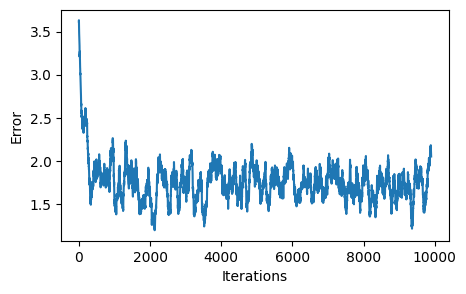

In [29]:
def moving_average(x, n=100) :
    ret = np.cumsum(x, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

moving_average_error = moving_average(np.array(error_list))
plt.figure(figsize=(5, 3))
plt.ylabel("Error")
plt.xlabel("Iterations")
plt.plot(np.arange(len(moving_average_error)), moving_average_error)
plt.show()

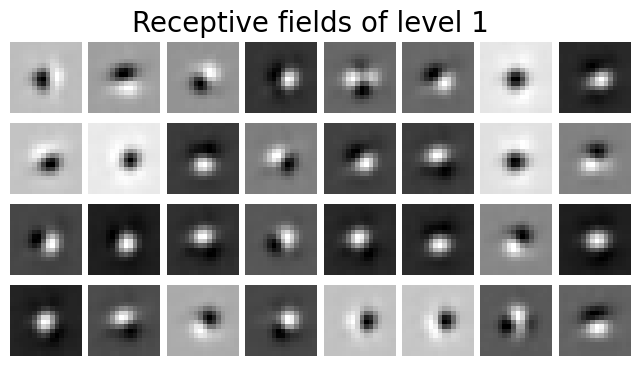

In [30]:
# Plot Receptive fields of level 1
fig = plt.figure(figsize=(8, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(32):
    plt.subplot(4, 8, i+1)
    plt.imshow(np.reshape(model.U[:, i], (16, 16)), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields of level 1", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.show()

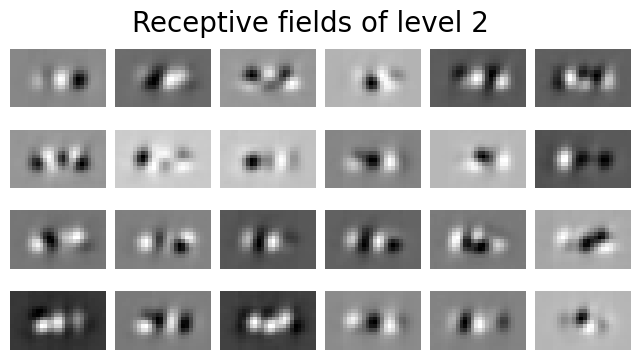

In [31]:
# Plot Receptive fields of level 2
zero_padding = np.zeros((80, 32))
U0 = np.concatenate((model.U, zero_padding, zero_padding))
U1 = np.concatenate((zero_padding, model.U, zero_padding))
U2 = np.concatenate((zero_padding, zero_padding, model.U))
U_ = np.concatenate((U0, U1, U2), axis = 1)
Uh_ = U_ @ model.Uh  

fig = plt.figure(figsize=(8, 4))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(np.reshape(Uh_[:, i], (16, 26), order='F'), cmap="gray")
    plt.axis("off")

fig.suptitle("Receptive fields of level 2", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.savefig("RF_level2.png")
plt.show()

In [23]:
imgs.shape

(512, 512, 10)

In [14]:
U.shape

(256, 32)

In [15]:
fx = model.r @ model.U.T

In [16]:
fx.shape

(3, 256)

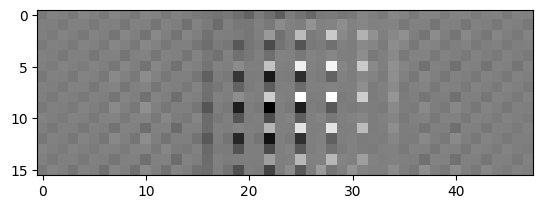

In [19]:
plt.imshow(np.reshape(fx, (16, -1), order='F'), cmap="gray")

In [20]:
fxh = model.Uh @ model.rh 

In [21]:
fxh.shape

(96,)